In [ ]:
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim

import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import torchtext.transforms as T
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

from tqdm.auto import tqdm

In [ ]:
SEED = 42

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Using {}'.format(device))

Using cuda


In [ ]:
!rm *.csv
!unzip Covid_Tweets.zip

rm: cannot remove '*.csv': No such file or directory
Archive:  Covid_Tweets.zip
  inflating: Covid_Tweets_test.csv   
  inflating: Covid_Tweets_train.csv  


In [ ]:
train_data = pd.read_csv('./Covid_Tweets_train.csv')

train_data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative


In [ ]:
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=SEED)

print(f'Number of training examples: {train_df.shape}')
print(f'Number of validation examples: {val_df.shape}')

Number of training examples: (32925, 2)
Number of validation examples: (8232, 2)


In [ ]:
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

In [ ]:
class CharacterTokenizerTransform(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, sentence):
    return list(sentence)

In [ ]:
char_tokenizer = CharacterTokenizerTransform()

tweet = "hi, this is a character-level tokenizer!"

tokenized = char_tokenizer(tweet)

print(f'Original: {tweet}')
print(f'Tokenized: {tokenized}')

Original: hi, this is a character-level tokenizer!
Tokenized: ['h', 'i', ',', ' ', 't', 'h', 'i', 's', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'h', 'a', 'r', 'a', 'c', 't', 'e', 'r', '-', 'l', 'e', 'v', 'e', 'l', ' ', 't', 'o', 'k', 'e', 'n', 'i', 'z', 'e', 'r', '!']


In [ ]:
tweet_lengths = [len(s) for s in train_df['OriginalTweet'].iloc]

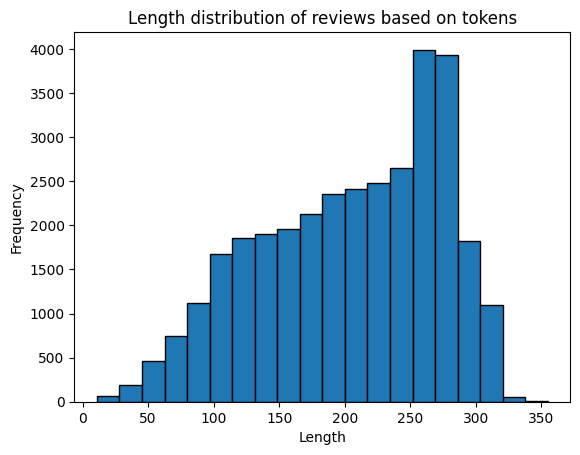

In [ ]:
def plot_length_distribution(lengths):
  plt.hist(lengths, bins=20, edgecolor='black')
  plt.xlabel('Length')
  plt.ylabel('Frequency')
  plt.title('Length distribution of reviews based on tokens')
  plt.show()

plot_length_distribution(tweet_lengths)

In [ ]:
pd.DataFrame({'lengths':tweet_lengths}).describe()

,lengths
count,32925.000000
mean,204.132422
std,68.708027
min,11.000000
25%,150.000000
50%,215.000000
75%,259.000000
max,355.000000


In [ ]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [ ]:
def yield_tokens(data_iter):
  for s in data_iter:
    yield char_tokenizer(s)

train_iter = iter(train_df['OriginalTweet'])
vocab_transform = build_vocab_from_iterator(
  yield_tokens(train_iter),
  specials=special_symbols,
  special_first=True
)

vocab_transform.set_default_index(UNK_IDX)

In [ ]:
print(f'Vocabulary size: {len(vocab_transform)}')

Vocabulary size: 141


In [ ]:
tweet = train_df['OriginalTweet'].iloc[0]
tokens = char_tokenizer(tweet)
ids = vocab_transform(tokens)

print(f'Original: {tweet}')
print(f'Tokens: {tokens}')
print(f'Ids: {ids}')

first_vocab_tokens = vocab_transform.get_itos()[:10]
last_vocab_tokens = vocab_transform.get_itos()[-10:]

print(f'First tokens: {first_vocab_tokens}')
print(f'Last tokens: {last_vocab_tokens}')






And the numbers are going to get bigger. https://t.co/fUeg2RL2dl
Tokens: ['U', 'n', 'e', 'm', 'p', 'l', 'o', 'y', 'm', 'e', 'n', 't', ' ', 'c', 'l', 'a', 'i', 'm', 's', ' ', 'm', 'a', 'd', 'e', ' ', 'o', 'n', 'l', 'i', 'n', 'e', ' ', 'i', 'n', ' ', 'V', 'i', 'r', 'g', 'i', 'n', 'i', 'a', ' ', 't', 'h', 'i', 's', ' ', 'w', 'e', 'e', 'k', ':', '\r', '\r', '\n', '\r', '\r', '\n', 'M', 'o', 'n', 'd', 'a', 'y', ':', ' ', '4', '2', '6', '\r', '\r', '\n', 'T', 'u', 'e', 's', 'd', 'a', 'y', ':', ' ', '2', ',', '1', '5', '0', '\r', '\r', '\n', '\r', '\r', '\n', 'A', 'n', 'd', ' ', 't', 'h', 'e', ' ', 'n', 'u', 'm', 'b', 'e', 'r', 's', ' ', 'a', 'r', 'e', ' ', 'g', 'o', 'i', 'n', 'g', ' ', 't', 'o', ' ', 'g', 'e', 't', ' ', 'b', 'i', 'g', 'g', 'e', 'r', '.', ' ', 'h', 't', 't', 'p', 's', ':', '/', '/', 't', '.', 'c', 'o', '/', 'f', 'U', 'e', 'g', '2', 'R', 'L', '2', 'd', 'l']
Ids: [61, 12, 5, 19, 18, 14, 6, 21, 19, 5, 12, 7, 4, 15, 14, 8, 11, 19, 9, 4, 19, 8, 16, 5, 4, 6, 12, 14, 11, 12, 5,

In [ ]:
import torchtext.transforms as T

MAX_SEQ_LEN = -1

def create_generation_transform(vocab_transform):
  text_tranform = T.Sequential(
    CharacterTokenizerTransform(),
    T.VocabTransform(vocab=vocab_transform),
    T.AddToken(SOS_IDX, True),
    T.AddToken(EOS_IDX, False),
    T.ToTensor()
  )
  return text_tranform

In [ ]:
text_generation_transform = create_generation_transform(vocab_transform)

In [ ]:
clean_tweet = train_df['OriginalTweet'].iloc[0]

transformed_tweet = text_generation_transform(clean_tweet)

print(f'Tweet: {clean_tweet}')
print(f'\nTransformed: {transformed_tweet}')

print('\nIds -> str: ', end='')
index_to_string = vocab_transform.get_itos()
for index in transformed_tweet:
  print(index_to_string[index], end=" ")






And the numbers are going to get bigger. https://t.co/fUeg2RL2dl

Transformed: tensor([ 2, 61, 12,  5, 19, 18, 14,  6, 21, 19,  5, 12,  7,  4, 15, 14,  8, 11,
        19,  9,  4, 19,  8, 16,  5,  4,  6, 12, 14, 11, 12,  5,  4, 11, 12,  4,
        44, 11, 10, 20, 11, 12, 11,  8,  4,  7, 13, 11,  9,  4, 24,  5,  5, 29,
        38, 27, 27, 33, 27, 27, 33, 46,  6, 12, 16,  8, 21, 38,  4, 74, 58, 76,
        27, 27, 33, 39, 17,  5,  9, 16,  8, 21, 38,  4, 58, 41, 34, 70, 50, 27,
        27, 33, 27, 27, 33, 42, 12, 16,  4,  7, 13,  5,  4, 12, 17, 19, 30,  5,
        10,  9,  4,  8, 10,  5,  4, 20,  6, 11, 12, 20,  4,  7,  6,  4, 20,  5,
         7,  4, 30, 11, 20, 20,  5, 10, 26,  4, 13,  7,  7, 18,  9, 38, 28, 28,
         7, 26, 15,  6, 28, 22, 61,  5, 20, 58, 54, 56, 58, 16, 14,  3])

 
 
 
 
 
 A n d   t h e   n u m b e r s   a r e   g o i n g   t o   g e t   b i g g e r .   h t t p s : / / t . c o / f U e g 2 R L 2 d l <eos> 

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_generation_fn(batch):
  tweets_batch = []
  for tweet in batch:
    tweet_transformed = text_generation_transform(tweet)
    tweets_batch.append(tweet_transformed)

  tweets_batch = pad_sequence(tweets_batch, padding_value=PAD_IDX)

  input_data = tweets_batch[:-1,:]
  output_data = tweets_batch[1:,:]

  return input_data.T, output_data.T

In [ ]:
BATCH_SIZE = 75

train_dl = DataLoader(
  list(train_df['OriginalTweet']),
  batch_size=BATCH_SIZE,
  shuffle=True,
  collate_fn=collate_generation_fn)

val_dl = DataLoader(
  list(val_df['OriginalTweet']),
  batch_size=BATCH_SIZE,
  shuffle=False,
  collate_fn=collate_generation_fn)

In [ ]:
input_data, output_data = next(iter(train_dl))

print(f'Input shape: {input_data.shape}')
print(f'Output shape: {output_data.shape}')

Input shape: torch.Size([75, 330])
Output shape: torch.Size([75, 330])


In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model=512, max_seq_length=2048):
    super(PositionalEncoding, self).__init__()
    self.d_model = d_model
    self.max_seq_length = max_seq_length

    pe = torch.zeros(max_seq_length, d_model)
    position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(1e+4) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    self.pe = pe.unsqueeze(0)
    self.pe.requires_grad = False

  def forward(self, X):
    return X + self.pe[:, :X.shape[1]].to(X.device)

  def __repr__(self):
    return f'{PositionalEncoding.__name__}(d_model={self.d_model}, max={self.max_seq_length})'

In [ ]:
class LangModel(nn.Module):
  def __init__(self, vocab_size, d_model, heads, num_layers, pad_indx):
    super(LangModel, self).__init__()
    self.num_layers = num_layers
    self.pad_idx = pad_indx
    self.embeddings = nn.Embedding(vocab_size, d_model, pad_indx)
    self.positions = PositionalEncoding(d_model, 1024)
    decoder_layer = nn.TransformerEncoderLayer(d_model, heads, batch_first=True, norm_first=True)
    self.decoder = nn.TransformerEncoder(decoder_layer, num_layers)
    self.fc = nn.Linear(d_model, vocab_size)

  def forward(self, X):
    seq = X.shape[1]
    attn_mask = torch.triu(torch.ones(seq, seq, dtype=torch.bool), 1).to(X.device)
    pad_mask = (X == self.pad_idx).to(X.device)

    z = self.positions(self.embeddings(X))
    z = self.decoder(z, mask=attn_mask, src_key_padding_mask=pad_mask)
    z = self.fc(z)

    return z

In [ ]:
class Trainer:
  def __init__(self):
    self.loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    self.history = {
      'train':{'loss':[], 'perplexity':[]},
      'val':{'loss':[], 'perplexity':[]},
    }

  def compute(self, batch, model, device):
    input_, output_ = batch
    input_ = input_.to(device)
    output_ = output_.to(device)

    logits = model(input_)

    loss = self.loss_fn(logits.reshape(-1, logits.shape[-1]), output_.reshape(-1))
    perplexity = torch.exp(loss)

    return loss, perplexity

  def train_phase(self, dl, model, optimizer, device, pbar):
    loss_total, perplexity_total, count = 0., 0., 0
    model.train()

    for it, batch in enumerate(dl):
      input_, _ = batch

      loss, perplexity = self.compute(batch, model, device)

      loss_total += loss.item() * input_.shape[0]
      perplexity_total += perplexity.item() * input_.shape[0]
      count += input_.shape[0]

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      pbar.set_postfix({'loss': loss.item(), 'perplexity': perplexity.item()})
      pbar.update(1)

    loss_total /= count
    perplexity_total /= count

    result = {'loss': loss_total, 'perplexity': perplexity_total}
    pbar.set_postfix(result)

    return result

  def val_phase(self, dl, model, device):
    loss_total, perplexity_total, count = 0., 0., 0
    model.eval()

    pbar = tqdm(total=len(dl), desc=f'Validating',  position=0, leave=False)
    for it, batch in enumerate(dl):
      input_, _ = batch

      loss, perplexity = self.compute(batch, model, device)

      loss_total += loss.item() * input_.shape[0]
      perplexity_total += perplexity.item() * input_.shape[0]
      count += input_.shape[0]

      pbar.set_postfix({'loss': loss.item(), 'perplexity': perplexity.item()})
      pbar.update(1)

    loss_total /= count
    perplexity_total /= count

    result = {'loss': loss_total, 'perplexity': perplexity_total}
    pbar.set_postfix(result)
    pbar.close()

    return result

  def train(self, train_dl, val_dl, model, epochs, optimizer, device, leave_bar=True):
    model = model.to(device)

    for epoch in range(1, epochs+1):
      pbar = tqdm(total=len(train_dl), desc=f'Epoch {epoch:02d}/{epochs}', position=0, leave=leave_bar)

      time_start = time.time()

      train_results = self.train_phase(train_dl, model, optimizer, device, pbar)
      val_results = self.val_phase(val_dl, model, device)

      time_elapsed = time.time() - time_start

      results = dict()
      for phase, result in {'train': train_results, 'val': val_results}.items():
        for score, value in result.items():
          self.history[phase][score].append(value)
          results[f'{phase}_{score}'] = value

      if leave_bar:
        pbar.set_postfix(results)
        pbar.close()
      else:
        pbar.close()
        elapsed = '{:02d}:{:02d}'.format(int(time_elapsed // 60), int(time_elapsed % 60))
        l = []
        for key, value in results.items():
            l.append(key + "=" + "{:.3f}".format(value))
        results_string = ", ".join(l)

        print(f'Epoch ({epoch:0>2}/{epochs}): time={elapsed}, ' \
              + results_string)

#compute(next(iter(train_dl)), model, loss_fn, device)

In [ ]:
model = LangModel(len(vocab_transform), 128, 4, 4, PAD_IDX)

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-8)

trainer = Trainer()

In [ ]:
model

LangModel(
  (embeddings): Embedding(141, 128, padding_idx=1)
  (positions): PositionalEncoding(d_model=128, max=1024)
  (decoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=141, bias=True)
)

In [ ]:
trainer.train(train_dl, val_dl, model, 10, optimizer, device)

Epoch 01/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 02/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 03/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 04/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 05/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 06/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 07/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 08/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 09/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/439 [00:00<?, ?it/s]

Validating:   0%|          | 0/110 [00:00<?, ?it/s]

In [ ]:
vocab_itos = vocab_transform.get_itos()
text = '@poggers is'
tokens = [ SOS_IDX ]
for i in text:
  tokens.append(vocab_transform.get_stoi()[i])
print(end=text)

temperature = 0.8
with torch.no_grad():
  for i in range(100):
    model.eval()
    input_ = torch.tensor([tokens]).to(device)
    smoothed_logits = model(input_)[:,-1,:].view(-1).div(temperature).exp()
    sampled_index = torch.multinomial(smoothed_logits, 1)

    if sampled_index == EOS_IDX:
      break

    predicted_char = vocab_itos[sampled_index.item()]
    tokens.append(sampled_index)
    text += predicted_char

    print(end=f"{predicted_char}")

print(f"\n{text}")

@poggers is a reaution by are levery appicates or show as a grocery store local to US.S in trat sture and of pa
@poggers is a reaution by are levery appicates or show as a grocery store local to US.S in trat sture and of pa


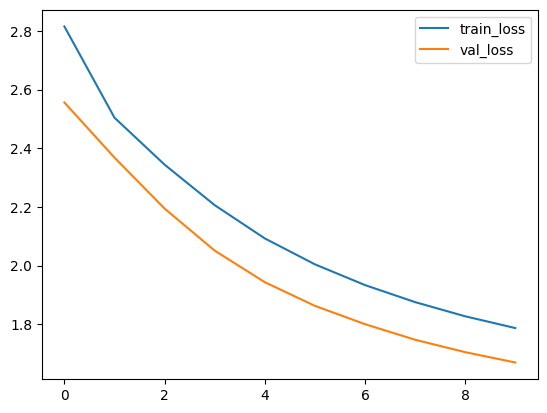

In [ ]:
plt.plot(trainer.history['train']['loss'], label='train_loss')
plt.plot(trainer.history['val']['loss'], label='val_loss')
plt.legend()

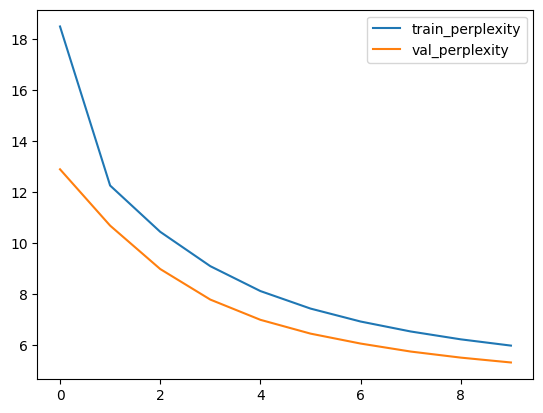

In [ ]:
plt.plot(trainer.history['train']['perplexity'], label='train_perplexity')
plt.plot(trainer.history['val']['perplexity'], label='val_perplexity')
plt.legend()